In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt

# Implementing the k-Means algorithm from scratch and testing numba speed-ups

k-Means is an unsupervised clustering algorithm. Given data points $x_i\in\mathbb{R}^n$ with $i\in\{1,\dots, N\}$ samples, the parameters of the model are the sets $S_\alpha$ with $\alpha\in\{1,\dots, k\}$ which define the cluster. These are defined by the centroids $\mu_\alpha$ where we have that 
$$
\forall x_i\in S_\alpha: \vert\vert x_i - \mu_\alpha\vert\vert^2 \leq \vert\vert x_i-\mu_\beta\vert\vert^2\quad \forall \beta\neq \alpha.
$$
\
The algorithm works in the following two steps that are repeated:\
1. The sets $S_\alpha$ are being determined for given (initialized in the first step) $\mu_\alpha$.

2. The centroids are updated by $\mu_\alpha\leftarrow \frac{1}{\vert S_\alpha\vert}\sum_{x_i\in S_\alpha}x_i$.

Let's generate a simple data set in $\mathbb{R}^2$ via the union of three Gaussian point clouds.

In [114]:
X = np.random.multivariate_normal([-1, 2], 0.25 * np.identity(2), size=(1000))
Y = np.random.multivariate_normal([0, 0], 0.25 * np.identity(2), size=(1000))
Z = np.random.multivariate_normal([2, 0], 0.25 * np.identity(2), size=(1000))
data = np.concatenate((X, Y , Z))

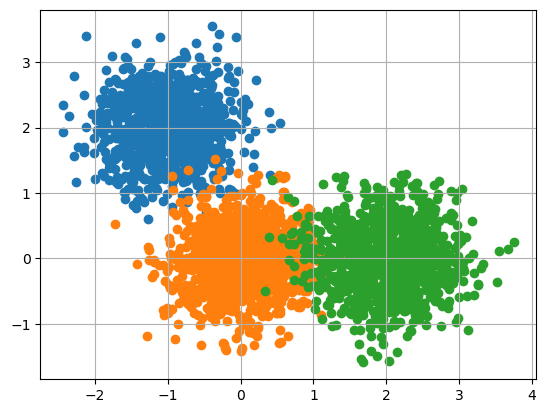

In [116]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])
ax.scatter(Y[:,0], Y[:,1])
ax.scatter(Z[:,0], Z[:,1])
ax.grid(True)
plt.show()

In [208]:
def initialize_centroids_naive(data, k):
    n_features = data.shape[1]
    mins = np.min(data, axis=0)
    maxs = np.max(data, axis=0)
    min_x, max_x = np.min(data[:,0]), np.max(data[:,0])
    min_y, max_y = np.min(data[:,1]), np.max(data[:,1])
    return np.array([np.random.uniform(mins[i], maxs[i], k) for i in range(n_features)]).reshape(k, n_features)

def initialize_centroids_forgy(data, k):
    return data[np.random.choice(data.shape[0], k, replace=False)]

def get_cluster(data, centroids):
    k = len(centroids)
    cluster_indxs = np.argmin(np.linalg.norm(data[:, None, :] - centroids[None, :, :], 2, axis=2), axis=1)
    cluster_sets = np.array([data[np.argwhere(cluster_indxs==alpha).T[0],:] for alpha in range(k)], dtype=object)
    return cluster_indxs, cluster_sets

def compute_centroid(cluster_sets):
    """
    For given set of indices that determine the set S_alpha (=arr) compute the new centroids
    """
    k = len(cluster_sets)
    return np.array([np.mean(cluster_sets[alpha], axis=0) for alpha in range(k)])

def k_means(data, k):
    N_steps = 0
    centroids = initialize_centroids_forgy(data, k)
    converged = False
    while converged == False:
        new_centroids = compute_centroid(get_cluster(data, centroids)[1])
        if np.allclose(new_centroids, centroids, atol=1e-6):
            converged = True
        else:
            centroids = new_centroids
            N_steps += 1
    return centroids, N_steps

#@numba.njit
def get_cluster_numba(data, centroids):
    N = len(data)
    k = len(centroids)
    cluster_indcs = []
    for i in range(N):
        distances = []
        for alph in range(k):
            distances.append(np.linalg.norm(data[i,:] - centroids[alph,:], 2))
        cluster_indcs.append(distances.index(min(distances)))
    cluster_sets = []
    for alph in range(k):
        cluster_sets.append([data[i] for i in range(N) if cluster_indcs[i] == alph])
    return cluster_sets

def k_means_numba(data, k):
    N_steps = 0
    centroids = initialize_centroids(data, k)
    converged = False
    while converged == False:
        new_centroids = compute_centroid(get_cluster_numba(data, centroids))
        if np.allclose(new_centroids, centroids, atol=1e-6):
            converged = True
        else:
            centroids = new_centroids
            N_steps += 1
    return centroids, N_steps

For the simple superposition of three Gaussian point clouds, the k-means algorithm is very fast for both implementations. Let's consider now the digits data set from scikit-learn, which are data points $x_i\in\mathbb{R}^64$ and where there are $10$ classes.

In [259]:
from sklearn.datasets import load_digits
from sklearn import metrics
data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
pred_centroids = k_means(data, 10)[0]

In [253]:
def pred_labels_k_means(data, labels, k):
    n_samples = data.shape[0]
    pred_centroids = k_means(data, k)[0]
    cluster_indcs = get_cluster(data, pred_centroids)[0]
    centroid_label_indcs = np.array([np.bincount(labels[np.argwhere(cluster_indcs==alph).T[0]]).argmax() for alph in range(k)])
    return np.array([centroid_label_indcs[cluster_indcs[i]] for i in range(n_samples)])

In [261]:
pred_labels = pred_labels_k_means(data, labels, 10)
accuracy = np.sum([1 for i in range(n_samples) if pred_labels[i] == labels[i]]) / n_samples 
print("The accuracy of the k-means prediction on the training set is", accuracy)

The accuracy of the k-means prediction on the training set is 0.7228714524207012


In [271]:
metrics.v_measure_score(labels, pred_labels)

0.7168470973411856